<a href="https://colab.research.google.com/github/inuwamobarak/OWLv2/blob/main/Introducing_OWLv2_Google's_Breakthrough_in_Zero_Shot_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Setting Up the Environment
In this step, we start by installing the 🤗 Transformers library from GitHub.

In [4]:
# Install the 🤗 Transformers library from GitHub.
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.4 MB/s eta 0:00:00


# Step 2: Load Model and Processor
Here, we load an OWLv2 checkpoint from the hub. Note that various checkpoint options are available, and in this example, we load an ensemble checkpoint.

In [5]:
# Load an OWLv2 checkpoint from the hub.
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# Load the processor and model.
processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

# Step 3: Load and Process Images
In this step, we load an image on which we want to detect objects.

In [6]:
# Load an image that you want to analyze.
from huggingface_hub import hf_hub_download
from PIL import Image

# Replace the file paths accordingly.
#filepath = hf_hub_download(repo_id="inuwamobarak/random-files", repo_type="dataset", filename="pexels-photo-2043590.jpeg")
filepath = hf_hub_download(repo_id="adirik/OWL-ViT", repo_type="space", filename="assets/astronaut.png")

image = Image.open(filepath)

# Step 4: Prepare image and queries for the model
OWLv2 is capable of detecting objects given text queries. In this step, we prepare the image and text queries for the model using the processor.

In [7]:
# Define the text queries that you want the model to detect.
texts = [['face', 'rocket', 'nasa badge', 'star-spangled banner']]

# Prepare the image and text for the model using the processor.
inputs = processor(text=texts, images=image, return_tensors="pt")

# Print the shapes of input tensors.
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 960, 960])


# Step 5: Forward Pass
In this step, we forward the prepared inputs through the model. We use torch.no_grad() to reduce memory usage since we don't need gradients at inference time.

In [8]:
# Import the torch library.
import torch

# Perform a forward pass through the model.
with torch.no_grad():
  outputs = model(**inputs)

# Step 6: Visualize Results
In this final step, we convert the model's outputs to COCO API format and visualize the results by drawing bounding boxes and labels on the image.

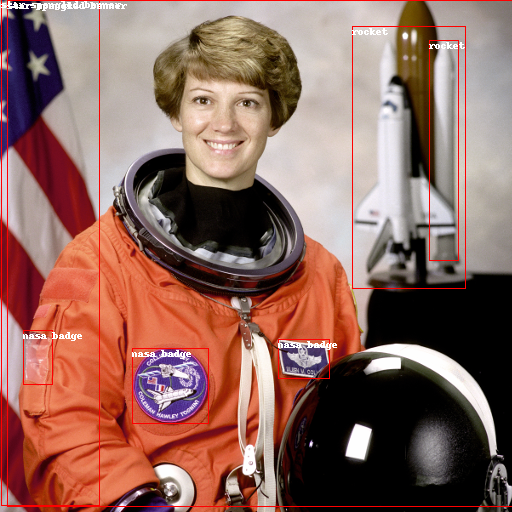

In [9]:
# Convert model outputs to COCO API format.
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)

# Retrieve predictions for the first image.
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Draw bounding boxes and labels on the image.
from PIL import ImageDraw
draw = ImageDraw.Draw(image)

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    x1, y1, x2, y2 = tuple(box)
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")

    draw.text(xy=(x1, y1), text=text[label])

# Display the image with bounding boxes and labels.
image

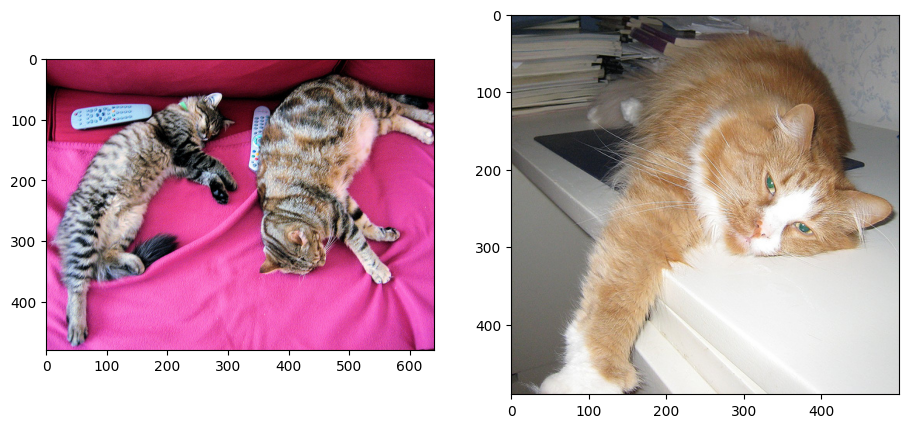

In [10]:
# Import necessary libraries and set figure size.
# %matplotlib inline  # Uncomment this line for compatibility if using Jupyter Notebook.
import cv2
from PIL import Image
import requests
import torch
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Set the figure size
rcParams['figure.figsize'] = 11, 8

# Load the input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Load the query image
query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display the input image and query image side by side.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(query_image)


In [11]:
# Define the device to use for processing.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Process input and query images using the preprocessor.
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print the input names and shapes.
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 960, 960])
pixel_values: torch.Size([1, 3, 960, 960])


In [12]:
# Perform image-guided object detection using the model.
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

# Print the shapes of the model's outputs.
for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 3600, 1])
image_embeds: shape of torch.Size([1, 60, 60, 768])
query_image_embeds: shape of torch.Size([1, 60, 60, 768])
target_pred_boxes: shape of torch.Size([1, 3600, 4])
query_pred_boxes: shape of torch.Size([1, 3600, 4])
class_embeds: shape of torch.Size([1, 3600, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 3601, 768])
pooler_output: shape of torch.Size([1, 768])


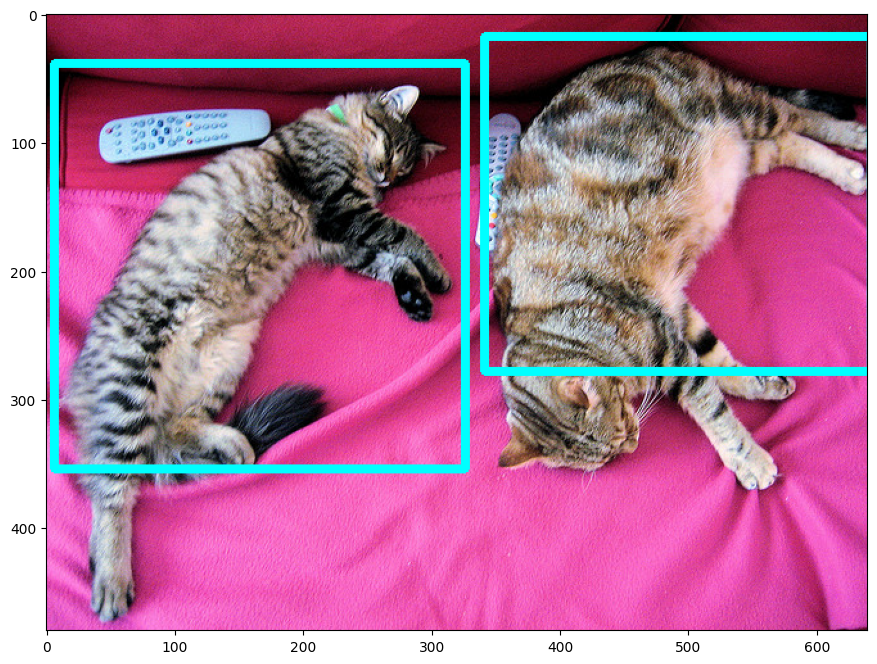

In [14]:
# Visualize the results
import numpy as np

# Convert the image to RGB format.
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

# Post-process the detection results.
results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.9, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw bounding boxes on the image.
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255, 255, 0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25

# Display the image with predicted bounding boxes.
plt.imshow(img[:, :, ::-1])